<img src="https://github.com/pmservice/ai-openscale-tutorials/raw/master/notebooks/images/banner.png" align="left" alt="banner">

# Tutorial on generating an explanation for an image-based model on Watson OpenScale

This notebook includes steps for creating an image-based watson-machine-learning model, creating a subscription, configuring explainability, and finally generating an explanation for a transaction.

### Contents
- [1. Setup](#setup)
- [2. Creating and deploying an image-based model](#deployment)
- [3. Subscriptions](#subscription)
- [4. Explainability](#explainability)

**Note**: If using Watson Studio, try running the notebook on at least 'Default Python 3.5 S' version for faster results (vs Python XS).

<a id="setup"></a>
## 1. Setup

### 1.1 Install Watson OpenScale and WML packages

In [1]:
!pip install watson-machine-learning-client
# !pip install --upgrade watson-machine-learning-client --no-cache | tail -n 1
# !pip install watson-machine-learning-client==1.0.371

In [2]:
!pip install ibm-ai-openscale
# !pip install --upgrade ibm-ai-openscale --no-cache | tail -n 1
# !pip install ibm-ai-openscale==2.1.16

     |████████████████████████████████| 573kB 18.9MB/s eta 0:00:01


Note: Restart the kernel to assure the new libraries are being used.

### 1.2 Configure credentials

To run this Lab you need to have a valid instance of Watson Openscale.

To verify if you have one, go to the [cloud console](https://cloud.ibm.com/resources), clicking on `Services` you should see your Watson OpenScale instance listed.

if not then from that screen click the upper right button **"Create ressource"**.
From the search entry type 'openscale' and create a lite plan of Watson OpenScale.

You also need a valid **IBM Cloud API Key** to assign the variable in the next cell.

To get it go to the [IBM Cloud console](https://console.bluemix.net/) then click from the upper toolbar `Manage->Access (IAM)`. 
Select `IBM Cloud API Keys` from the left hand sidebar and then click the **"Create an IBM Cloud API Key"** button.

From that page, give your key a name and click Create, then copy the created key and paste it below. 

In [3]:
CLOUD_API_KEY = "<PASTE HERE>"


import requests
from ibm_ai_openscale.utils import get_instance_guid

WOS_GUID = get_instance_guid(api_key=CLOUD_API_KEY)
AIOS_CREDENTIALS = {
    "instance_guid": WOS_GUID,
    "apikey": CLOUD_API_KEY,
    "url": "https://api.aiopenscale.cloud.ibm.com"
}

if WOS_GUID is None:
    print('Watson OpenScale GUID NOT FOUND')
else:
    print(WOS_GUID)
print(AIOS_CREDENTIALS)

70ee9046-f34e-441c-8dbe-75d57d88b6f7
{'instance_guid': '70ee9046-f34e-441c-8dbe-75d57d88b6f7', 'apikey': 'CQRxiAj_K5-AZPh13JROMfsZYNH0G8LMVaCAEdrx0_Ky', 'url': 'https://api.aiopenscale.cloud.ibm.com'}


You also need to have a valid instance of Watson Machine Learning (runtime for your models) running.

To verify if you have one, go to the [cloud console](https://cloud.ibm.com/resources), clicking on `Services` you should see your Watson Machine Learning instance listed.

if not then from that screen click the upper right button **"Create ressource"**.
From the search entry type 'Machine Learning' and create a lite plan of Watson Machine Learning. 
MAKE SURE THE REGION FIELD GOT **DALLAS** as value if not modify it accordingly.

From the IBM Cloud Resource list click on the Watson Machine Learning instance and from this page click the service credentials side bar item.
clik on view **'credentials'** and copy the all json info provided as follow :

```
{
  "apikey": "XXXXXXXXXX",
  "iam_apikey_description": "Auto-generated for key XXXX-YYYYY-ZZZZZZ",
  "iam_apikey_name": "WML-credentials",
  "iam_role_crn": "crn:v1:bluemix:public:iam::::serviceRole:Writer",
  "iam_serviceid_crn": "crn:v1:bluemix:public:iam-identity::a/XXXXXXXX::serviceid:ServiceId-XXXX-YYYYYY-ZZZZZZZZ",
  "instance_id": "WWWWWWWWWWWWWWWW",
  "url": "https://us-south.ml.cloud.ibm.com"
}
```   
    

replace the following variable with the obtained json data.

In [4]:
# WML4JLC
WML_CREDENTIALS = {
  "apikey": "XXXXXXXXXX",
  "iam_apikey_description": "Auto-generated for key XXXX-YYYYY-ZZZZZZ",
  "iam_apikey_name": "WML-credentials",
  "iam_role_crn": "crn:v1:bluemix:public:iam::::serviceRole:Writer",
  "iam_serviceid_crn": "crn:v1:bluemix:public:iam-identity::a/XXXXXXXX::serviceid:ServiceId-XXXX-YYYYYY-ZZZZZZZZ",
  "instance_id": "WWWWWWWWWWWWWWWW",
  "url": "https://us-south.ml.cloud.ibm.com"
}


In [5]:
import sys, time

def Wait(seconds, Speed=5):
    Chars = ["|","/","-","\\"]
    MaxChars = 4
    sys.stdout.flush()
    for i in range(seconds*Speed):
        sys.stdout.write("\r" + Chars[i % MaxChars])
        sys.stdout.flush()
        time.sleep(1/Speed)
    sys.stdout.write("\r ")
Wait(10)

<a id="deployment"></a>
## 2. Creating and deploying an image-based model

    The dataset used is FER (Facial Emotional Recogniton) dataset of a Kaggle challenge. 

Note: Tensorflow versions supported by WML are: 1.2, 1.5, and 1.11. Make sure you have one of these versions before creating the models. Version 1.11 is used in this notebook.

### 2.1 Creating a model

In [6]:
!pip install keras
!pip install tensorflow==1.11.0
!pip install keras_sequential_ascii

import keras
from keras_sequential_ascii import sequential_model_to_ascii_printout

     |████████████████████████████████| 63.0MB 59.6MB/s eta 0:00:01
     |████████████████████████████████| 573kB 44.4MB/s eta 0:00:01
     |████████████████████████████████| 3.0MB 39.0MB/s eta 0:00:01
  Found existing installation: setuptools 40.8.0
    Uninstalling setuptools-40.8.0:
      Successfully uninstalled setuptools-40.8.0
  Found existing installation: tensorflow 1.13.1
    Uninstalling tensorflow-1.13.1:
      Successfully uninstalled tensorflow-1.13.1
  Stored in directory: /home/dsxuser/.cache/pip/wheels/f5/8d/81/912666dff82a923ce423a7e797cd75f54271c7031512cdb282
Successfully built keras-sequential-ascii


Using TensorFlow backend.


In [7]:
print("KERAS v {}".format(keras.__version__))

import tensorflow as tf
print("TENSORFLOW v {}".format(tf.__version__))

KERAS v 2.2.4
TENSORFLOW v 1.11.0


THe goal of this lab is to evaluate the explainability of the model not to train it.
So the next step is to load from the lab folder the associated pre-trained model and use it as is.
You have the definition and trained weights of the model in a file called **_mini_XCEPTION.102-0.66.hdf5**

**Keras also supports a simpler interface to save both the model weights and model architecture together into a single H5 file, 
while the HDF5 format store only Model weights and therefore the model architecture is provided as a JSON format.**
    
* Saving/Loading the model in H5 includes everything we need to know about the model, including:
    - Model weights.
    - Model architecture.
    - Model compilation details (loss and metrics).
    - Model optimizer state.
* This means that we can load and use the model directly, without having to re-compile it.


To upload the HDF5 file and use it please procedd as follow :
From the upper toolbar select the *01* icon and Files tab, then drag/drop the file **_mini_XCEPTION.102-0.66.hdf5**
Therefore the file appears in the right hand side bar.

Move your cursor on the cell bellow and remove everything (cell fully empty !)

Once done click the drop down arrow of the right hand side window where **_mini_XCEPTION.102-0.66.hdf5** is and select **insert to code>>Insert Streaming Object**

the equivalent of the following should appear with your own project COS credentials

```
import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_8a2a8e9ef5a44a08aaca7ec89672ecaa = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='xxxxxxxxxxxxx',
    ibm_auth_endpoint="https://iam.ng.bluemix.net/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

# Your data file was loaded into a botocore.response.StreamingBody object.
# Please read the documentation of ibm_boto3 and pandas to learn more about the possibilities to load the data.
# ibm_boto3 documentation: https://ibm.github.io/ibm-cos-sdk-python/
# pandas documentation: http://pandas.pydata.org/
streaming_body_1 = client_8a2a8e9ef5a44a08aaca7ec89672ecaa.get_object(Bucket='XXXXXXX', Key='_mini_XCEPTION.102-0.66.hdf5')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(streaming_body_1, "__iter__"): streaming_body_1.__iter__ = types.MethodType( __iter__, streaming_body_1 ) 

```   

You also need to retrieve the bucket name of you Cloud Object Storage (COS) from the inserted code and then insert it into the cell where you will need to download files from the COS (see sample below)

client_xxxxxxxx.get_object(<span style="background-color: #FFFF00"> Bucket='my-generated-bucket-name-123245566788' </span>, Key='HandWrittenDigit-CNN.h5')['Body']

```
client_COS.download_file(Bucket='<inset your bucket-name here>',Key='HandWrittenDigit-CNN.h5',Filename='HandWrittenDigit-CNN.h5')

```

Last but not least rename the variable called **'client_8a2a8e9ef......72ecaa'** with **ClientCOS** (a bit more clear and reusable for the rest of the notebook !


You're now ready to usethe HDF5 definition and weights for your model instead of having to retrain it.

In [31]:

import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_8a2a8e9ef5a44a08aaca7ec89672ecaa = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='SgL3gHSfOX7WRMxOLrrvDiDvOl8Z0aCkeMIL9S3j-9Ge',
    ibm_auth_endpoint="https://iam.ng.bluemix.net/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

# Your data file was loaded into a botocore.response.StreamingBody object.
# Please read the documentation of ibm_boto3 and pandas to learn more about the possibilities to load the data.
# ibm_boto3 documentation: https://ibm.github.io/ibm-cos-sdk-python/
# pandas documentation: http://pandas.pydata.org/
streaming_body_1 = client_8a2a8e9ef5a44a08aaca7ec89672ecaa.get_object(Bucket='demoai-donotdelete-pr-odc7lk3sakuluh', Key='_mini_XCEPTION.102-0.66.hdf5')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(streaming_body_1, "__iter__"): streaming_body_1.__iter__ = types.MethodType( __iter__, streaming_body_1 ) 


In [32]:
ClientCOS = client_8a2a8e9ef5a44a08aaca7ec89672ecaa

In [33]:
!rm *
OriginalModelFile = '_mini_XCEPTION.102-0.66.hdf5'

ReTrainModel = 5
try:
    ClientCOS.download_file(Bucket='demoai-donotdelete-pr-odc7lk3sakuluh', Key=OriginalModelFile,Filename=OriginalModelFile)
except:
    # Model never created tbd
    RetrainModel = 1
else:
    RetrainModel = 0
print("Model to be retrain : ", RetrainModel)
!ls

Model to be retrain :  0
_mini_XCEPTION.102-0.66.hdf5


In [34]:
from keras.models import load_model

if RetrainModel == 0:
    cnn_n = load_model(OriginalModelFile)
else:
    cnn_n = sequential()

In [35]:
# Vizualizing model structure
sequential_model_to_ascii_printout(cnn_n)

           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####     64   64    1
          InputLayer     |   -------------------         0     0.0%
                       #####     64   64    1
              Conv2D    \|/  -------------------        72     0.1%
                       #####     62   62    8
  BatchNormalization    μ|σ  -------------------        32     0.1%
                relu   #####     62   62    8
              Conv2D    \|/  -------------------       576     1.0%
                       #####     60   60    8
  BatchNormalization    μ|σ  -------------------        32     0.1%
                relu   #####     60   60    8
     SeparableConv2D    /|\x -------------------       200     0.3%
                       #####     60   60   16
  BatchNormalization    μ|σ  -------------------        64     0.1%
                relu   #####     60   60   16
     SeparableConv2D    /|\x -------------------       400     0.7%
              

In [36]:
# dictionary which assigns each label an emotion (alphabetical order)
EMOTIONS_DICT = {0: "Angry", 1: "Disgusted", 2: "Fearful", 3: "Happy", 4: "Neutral", 5: "Sad", 6: "Surprised"}

### 2.2 Storing the model

In [37]:
from watson_machine_learning_client import WatsonMachineLearningAPIClient

wml_client = WatsonMachineLearningAPIClient(WML_CREDENTIALS)

In [38]:
model_name = "FER-Model-HDF5"

import os
os.system('rm'+model_name+'*')

TarModelFile = model_name + '.tar.gz'
print('tar -czvf '+ TarModelFile + ' '+OriginalModelFile)
os.system('tar -czvf '+ TarModelFile + ' '+OriginalModelFile)
# !tar -czvf FER-Model-HDF5.tar.gz _mini_XCEPTION.102-0.66.hdf5

tar -czvf FER-Model-HDF5.tar.gz _mini_XCEPTION.102-0.66.hdf5


0

In [39]:
os.system('rm '+OriginalModelFile)
!ls

FER-Model-HDF5.tar.gz


In [40]:
# Update the FRAMEWORK_VERSION below depending on the tensorflow version used
model_meta = {
    wml_client.repository.ModelMetaNames.NAME: model_name,
    wml_client.repository.ModelMetaNames.DESCRIPTION: model_name + " from Kaggle",
    wml_client.repository.ModelMetaNames.FRAMEWORK_NAME: "tensorflow",
    wml_client.repository.ModelMetaNames.FRAMEWORK_VERSION: "1.11",
    wml_client.repository.ModelMetaNames.FRAMEWORK_LIBRARIES: [
         {"name": "keras", "version": "2.2.4"}
    ]
}
model_meta

{'name': 'FER-Model-HDF5',
 'description': 'FER-Model-HDF5 from Kaggle',
 'frameworkName': 'tensorflow',
 'frameworkVersion': '1.11',
 'frameworkLibraries': [{'name': 'keras', 'version': '2.2.4'}]}

In [41]:
# wml_client.repository.delete('3d1e459d-7f1c-4b72-9a65-75573defedc5')
# wml_client.deployments.delete('c66a80cc-1031-4ca2-a6a2-0076e7b6bd48')
wml_client.repository.list()

------------------------------------  ------------------------------------  ------------------------  ---------------  -----------------
GUID                                  NAME                                  CREATED                   FRAMEWORK        TYPE
13bc8f83-ec48-41e5-ba28-dee6154e2080  Spark German Risk Model - Final       2019-11-08T10:03:42.944Z  mllib            definition
91e232a5-0bc8-4916-81f7-19be81aa33bf  Spark German Risk Model - Final       2019-10-02T10:13:10.364Z  mllib            definition
812f030f-56c7-4231-a24e-0d0ed9fb917c  Spark German Risk Model - Final       2019-09-30T19:39:32.021Z  mllib            definition
85c80a15-a03e-45b6-904d-806a291e260a  Spark German Risk Model - Final       2019-09-30T17:51:50.181Z  mllib            definition
60d3a487-1f32-4fd4-9a49-7ea85001306d  Spark German Risk Model - Final       2019-09-30T17:50:29.777Z  mllib            definition
35a9ed96-fc11-4129-9a96-f83f71020694  Spark German Risk Model - Final       2019-09-30T17

In [42]:
# published_model_details = wml_client.repository.get_details('7d7d20b6-6e54-4643-ae14-f99f41f0f986')

In [43]:

published_model_details = wml_client.repository.store_model(model=TarModelFile, meta_props=model_meta)

Note: Model of framework tensorflow and versions 1.5/1.11 has been deprecated. These versions will not be supported after 26th Nov 2019.


In [44]:
model_uid = wml_client.repository.get_model_uid(published_model_details)
model_uid 

'e54b4319-e18e-419f-bf70-85331d592327'

### 2.3 Deploying the model

In [45]:
deployment= wml_client.deployments.create(name= model_name + " Deployment", model_uid=model_uid)

Note: Model of framework tensorflow and versions 1.5/1.11 has been deprecated. These versions will not be supported after 26th Nov 2019.


#######################################################################################

Synchronous deployment creation for uid: 'e54b4319-e18e-419f-bf70-85331d592327' started

#######################################################################################


INITIALIZING
DEPLOY_IN_PROGRESS....
DEPLOY_SUCCESS


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='8c75c216-fbaa-422a-a3a7-6daa8a90fc2c'
------------------------------------------------------------------------------------------------




In [46]:
scoring_url = wml_client.deployments.get_scoring_url(deployment)
print(wml_client.deployments.list())
print(scoring_url)

------------------------------------  ------------------------------------  ------  --------------  ------------------------  ---------------  -------------
GUID                                  NAME                                  TYPE    STATE           CREATED                   FRAMEWORK        ARTIFACT TYPE
8c75c216-fbaa-422a-a3a7-6daa8a90fc2c  FER-Model-HDF5 Deployment             online  DEPLOY_SUCCESS  2019-11-19T20:13:14.651Z  tensorflow-1.11  model
a37e9118-fc41-4351-9946-6442bd47d79d  FER-Model-HDF5 Deployment             online  DEPLOY_SUCCESS  2019-11-19T20:08:48.765Z  tensorflow-1.11  model
fb964106-2a52-456b-b356-dac31e927d65  Spark German Risk Deployment - Final  online  DEPLOY_SUCCESS  2019-11-08T10:04:03.940Z  mllib-2.3        model
610ff1b2-d6f5-4e69-a91c-5c357451fba9  created using neunets                 online  DEPLOY_SUCCESS  2019-11-06T17:35:36.873Z  tensorflow-1.5   model
1d39be4d-7fb0-4f5d-9584-7e3c75e6a351  created using neunets                 online  DEPLOY

## 3. Subscriptions

### 3.1 Configuring OpenScale

In [47]:
from ibm_ai_openscale import APIClient
from ibm_ai_openscale.engines import WatsonMachineLearningAsset

aios_client = APIClient(AIOS_CREDENTIALS)
aios_client.version

'2.1.18'

In [48]:
#  CLEAN SUBSCRIPTION ENTRIES
subscriptions_uids = aios_client.data_mart.subscriptions.get_uids()
for subscription in subscriptions_uids:
    sub_name = aios_client.data_mart.subscriptions.get_details(subscription)['entity']['asset']['name']
    if sub_name == model_name:
        aios_client.data_mart.subscriptions.delete(subscription)
        print('Deleted existing subscription for', model_name)

Deleted existing subscription for FER-Model-HDF5


### 3.2 Subscribe the asset

In [49]:
from ibm_ai_openscale.supporting_classes import *

Asset = WatsonMachineLearningAsset(model_uid,
                                   problem_type=ProblemType.MULTICLASS_CLASSIFICATION,
                                   input_data_type=InputDataType.UNSTRUCTURED_IMAGE,
                                   probability_column='probability'
                                  )
subscription = aios_client.data_mart.subscriptions.add(Asset)

In [50]:
# aios_client.data_mart.subscriptions.delete('9d891fc1-4455-4566-b797-2472171abc03')
aios_client.data_mart.subscriptions.list()

5e0044fe-9c1e-4b21-bd60-08def28fa4d8,FER-Model-HDF5,model,febb80c2-33af-4014-8dd8-ef2170ff4cfb,2019-11-19T20:13:59.163Z
e56ffa07-970d-4d74-b284-1e1e03244544,MNIST Model,model,febb80c2-33af-4014-8dd8-ef2170ff4cfb,2019-11-12T14:14:59.425Z
087a04a9-2318-472e-ad42-3783b631666b,Spark German Risk Model - Final,model,febb80c2-33af-4014-8dd8-ef2170ff4cfb,2019-11-08T10:04:43.254Z
b5079da2-264b-43e8-a71f-a9ee23208832,FER-Kaggle,model,febb80c2-33af-4014-8dd8-ef2170ff4cfb,2019-10-16T11:26:28.635Z
c50ada6b-a76e-42be-b000-831d519dda63,FER-2013,model,febb80c2-33af-4014-8dd8-ef2170ff4cfb,2019-10-09T22:18:02.029Z


In [51]:
subscription.get_details()

{'entity': {'asset': {'asset_id': 'e54b4319-e18e-419f-bf70-85331d592327',
   'asset_type': 'model',
   'created_at': '2019-11-19T20:13:14.618Z',
   'name': 'FER-Model-HDF5',
   'url': 'https://us-south.ml.cloud.ibm.com/v3/wml_instances/febb80c2-33af-4014-8dd8-ef2170ff4cfb/published_models/e54b4319-e18e-419f-bf70-85331d592327'},
  'asset_properties': {'input_data_type': 'unstructured_image',
   'model_type': 'tensorflow-1.11',
   'probability_fields': ['probability'],
   'problem_type': 'multiclass',
   'runtime_environment': 'None Provided'},
  'configurations': [{'enabled': True,
    'monitor_definition_id': 'payload_logging',
    'type': 'payload_logging',
    'url': '/v1/data_marts/70ee9046-f34e-441c-8dbe-75d57d88b6f7/service_bindings/febb80c2-33af-4014-8dd8-ef2170ff4cfb/subscriptions/5e0044fe-9c1e-4b21-bd60-08def28fa4d8/configurations/payload_logging'},
   {'enabled': False,
    'monitor_definition_id': 'explainability',
    'type': 'explainability',
    'url': '/v1/data_marts/70ee

In [52]:
!pip install opencv_python

import cv2
import numpy as np

ClientCOS.download_file(Bucket='demoai-donotdelete-pr-odc7lk3sakuluh', Key='face-test4.jpg',Filename='face-test4.jpg')

img = cv2.imread('face-test4.jpg')
grayImg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = cv2.resize(grayImg, (64, 64))
test_image = img.reshape([-1,64,64,1])
test_image = np.multiply(test_image, 1.0 / 255.0)

image_as_array = np.asarray(test_image)
scoring_payload = {'values': image_as_array.tolist()}

predictions = wml_client.deployments.score(scoring_url, scoring_payload)
print(json.dumps(predictions, sort_keys=True, indent=4))

{
    "fields": [
        "prediction"
    ],
    "values": [
        [
            0.0008969628252089024,
            9.394787412020378e-06,
            0.009640260599553585,
            0.02122584916651249,
            0.007926308549940586,
            0.8861942291259766,
            0.0741070955991745
        ]
    ]
}


### 3.3 Score the model and get transaction-id

In [53]:
Wait(60)
print (subscription.payload_logging.get_table_content())
transaction_id = subscription.payload_logging.get_table_content().scoring_id[0]
transaction_id

                            scoring_id                scoring_timestamp  \
0  fb6a38ba7d6d460682a3c40d9827ee70-1 2019-11-19 20:14:06.909519+00:00   

                          deployment_id                        asset_revision  \
0  8c75c216-fbaa-422a-a3a7-6daa8a90fc2c  0236bb37-391d-442c-b0d8-f98ca6f9d0f8   

                                       scoring_input  prediction_probability  \
0  [[[0.39215686274509803], [0.39215686274509803]...                0.886194   

   scoring_prediction                                         prediction  
0                   5  [0.0008969628252089024, 9.394787412020378e-06,...  


'fb6a38ba7d6d460682a3c40d9827ee70-1'

<a id="explainability"></a>
## 4. Explainability

### 4.1 Configure Explainability

In [54]:
subscription.explainability.enable()

In [55]:
subscription.explainability.get_details()

{'enabled': True}

### 4.2 Get explanation for the transaction

**Explaining image model transactions**

For an image classification model example of explainability, you can see which parts of an image contributed positively to the predicted outcome and which contributed negatively. In the following example, the image in the positive pane shows the parts which impacted positively to the prediction and the image in the negative pane shows the parts of images that had a negative impact on the outcome.

If you get an error in the next cell..... something ending by KeyError: 'cem_state' .....

it's a bug :( in the library, but still you can collect see the result by retrieving the transaction_id from the upper cell

```
transaction_id = subscription.payload_logging.get_table_content().scoring_id[0]
transaction_id
```

then open the following webpage and paste the transaction_id and search for it, you will see the result of the image model explainability.

https://aiopenscale.cloud.ibm.com/aiopenscale/explain


In [76]:
explanation = 0
try :
    explanation = subscription.explainability.run(transaction_id, background_mode=False,cem=False)
    RunID = explanation["metadata"]["id"]
except:
  print("Something went wrong")
  explanation = {
    "entity": {
        "asset": {
            "deployment": {
                "id": "97c65a3c-f332-4144-80c6-6cca6a6433c8",
                "name": "FER-Model-HDF5 Deployment"
            },
            "id": "13ad79e4-0672-457d-a03b-60667e8fddc5",
            "name": "FER-Model-HDF5",
            "type": "image"
        },
        "explanation_type": "lime",
        "input_features": [
            {
                "full_image": "iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAIAAAAlC+aJAAAS9ElEQVR42n1aW28T1/edy5mrxzMe24ntOCSQFGgRCFREWwq9vFC1VaVKfIYiISG136jlC/DaNyq1VK1ahFBRuIimUIghTpw4vsz9+ntYsHPq8P/Pg+U44/E++7L22usc8ZtvvhEEQRAEURTLshT+e9En5etLkqQ8z/FJnueiKAqCoOu6JEme5w2HQ8ZYkiSiKJqmaVmWoihlWU6n0+PHj9dqtUajMR6PJUlaWVlRFMV13WazaVmWLMt4FCzhX4uiyPM8y7IkSbIsy/O84C4mSRJvMb5GdmNVZVmKoohn4V9pmnqeFwRBkiSKooxGo+l0mmVZGIamaU4mE0VRNE0zTZMxVhSFqqpPnjxRFMU0TUVR8jxfXl6u1+sXLlxIkqRWq83NzTHGyIAZk/glzfyL8Z/O3EExwZuiKGRZnk6nk8nE9/0kSeCYOI739vYQENu2FUXpdruTyaQoCt/3K5VKGIZhGBZFEUVRq9UyTXN3d3d9fb1SqaytrV28ePH8+fOIBu/Ng8bQxf93dgFk8cFcEkVxe3vb87wkSXZ3dz3P8zyPMQZn27bNGJMkSVEUQRAcx5lOp6IoapqGJMmybDgc6ro+Pz+/ubk5Pz+f5/nLly9v3Ljx/Pnzy5cvC4JgGIZpmjMGiAcupLEkSUVR/J8RoJVQUg2Hw9FoFMexKIq2bdfrdWRhkiTwsWEYS0tLmqY1Gg1BEJIk6ff7six7npfneaPRqNfrcRw/f/7cMAzLsobDoSAI9Xp9NBpdv3690+msrKycO3eu0+kYhkHmHqxM/tqvAd738DfdhOiPx+OiKBqNhqqq/GqTJJlOp3EcB0GwubnZarUEQWCMua7ruu5oNJJlWdd1WZar1SqyyPf9nZ2dTqdTlmUURWVZzs3NbW1tiaJ4//79Dz744MKFC7Zta5p2sAxmc+natWsz/sZ7epUkCZaVZbmwsGCapiiKuq7Hcayqqu/7aZrKshwEge/7e3t7jUajLEvbtrMsW1xcZIwFQRCGoaqqkiSJohjHcZ7nlUoFOVYUxWAwWFhYCIIgy7JOp6OqqmmaH3300fHjx+GssiyzLEvTNE3TPM9Rb3hlBwucPsEadnd3B4PB3Nxct9s1TdM0TVmWZVmmO5MkQWHkeT4ejweDgWEYWZY5jjOZTCRJQmYnSVKWpaIotVpNVdWiKCzLCsPQdV3Lssbj8crKCrzg+74kSbdu3ZpMJmfOnLEs62AWwbx9FJpBT7xRVbXf7w+Hw1artbS0ZNu2ruuCIGiaJstyWZaapgFkK5VKlmWiKC4sLJw+fTpNU9/3syzTdR0tQpblPM8B4aIopmmK4tE0rdfrdbtdPNN1XdM0X7586XleURR//vmnrusnT54EwvI5QinDJEk6mPG4aTwe+77faDQOHz5cq9UURdF1HSBA7/FFx3HQbvBfXGhhuCfLMkQ8z/M4juM49jzPtm30uyzLZFl++vRpu922bbtSqQRBgC/evHnTdd1Dhw4djAAcPZtCiDIA3vM813W73a7jOIZhwJHATVVVGWNon7Is41+wHhWMD/nHwnT4XhAEz/PSNM2yzDRNSZJQMP/++2+SJJ1Op9frBUFQqVSKorh169alS5eazSY5l89wxv9N7TaKoul0Wq1WHcep1WqapsFQxpiqqoqi4I0kSWQrXnHRhwgvtX1d1/PXF71HXRZFgZTb2dmJomhhYaHf74dh6HmeruuPHj06e/YsYwzm8f2K8fAEb2VZ5vu+4zhlWdZqNSSx8vpCBNjrC6sSRVFRFJiOpQqCgAgAx5C1RVEwxhBeRVGAKrIsA2HyPFdVtdFooG3Pzc0Nh8M8zx8/flwURbPZPHz4MB9SPJwh7jx0IkHzPEdXogqBfaqqIn/gYHgaqyJ0wr/4TIX1xKawDIIyoCS+BYzOsqxarWZZBnviOF5bW1tYWEBdwSQ8kJFxFOsoioqiMAyjWq2i/CVJ0jRN0zSwBhiN36acoYynepgpOPR/3oV4CCgWPJXnOWMsTVM8EADqeZ4gCFtbW/1+f3FxcYahSRQBmKKqKkDdtm2qWnItMgQXUojnJxQQ/Ilv4U/+Hryh1FUUBe8pOYHRWJgkSXEcS5KELgkX82R5H0bxis5qmib8TZlDOc13DHyFPqci5vGOCoAqDTfgThgEi8uyRN/NsgwRINjxfZ8xtrOzQ5EkAxhPgWBrmqb1et00TQqLLMuoYKoWfvjgfXwQEnh2iCSZGZUEQZBlmfCR1ixJEoYNKoM4jnmehifs/zYVQJ7noOZ80Anv+Rzgc4YaJKLPN3Uaqfh5iu+ehODITOQtksq2bdd1sQw0EL69CIIg7ScTY+DJlmWpqkrh5nsWtWpKHvI3nk7ZQhbzdsP9gHx8wseTxiY+7LIsNxoNohIHx93/1IAsy3Eca5r2alZgjMY8+g2UJsEOzKJ85REZ9hHk4X2WZViA+KaLT1ECFUxLeZ6jP/BeK8uS8W0Ywy7BPBIR+EMNi69XalJYA+8LWAzigD/jOE6SBKQVdlBr59OP1g/6BJdZlhUEAYYK/DoCLggCo7oB5RIEAfMUZQgemiQJumYURQguOhoABLhBzkY0qOdjJZh4cANWgl+pVCqVSoXQHbyVvgWeJwgCeoKqqjCSEo/xmY3UBPOBk0RRjKIoSRJQICSlKIqU01AckPT8MESoQsOHKIokn2CReZ77vu953ng8rtfrBFNU01BoINLoum4YBs8YXpUuD9gwZTqd1ut1WAnFAW24UqmAQvP9nzodkhtQy5tOXI1kJZ6NVSoVWZbH4/HW1hYiD0vwKKouJKdt2zy47XMhfkHD4bDdbtPk3+v1XNdtt9tYfRAEPEoQmcGYNjO2Igd838cEk6YpIklMAbCBGlVVdTKZGIZB3BaQhSKBF5BgMwDNePzC79G6fd83TbNWq4miOJlM4jgGNKVpahgGnI3hsCgKNG8UOoxLkgTyEVAc0dja2oLUhbFYURRISeC8PHWFO+CXLMuCIBgOh77v42n7qsT+O8bgIfwkMqFWqyHESMRnz555nnf06FF0R0VRsCTMmdRW4ZQ8z6MogrCF8k3TdHd3dzgcuq4Lv4BUI2FQoHgakQUsA3wpDMMZevuKzPGyYRzHKHNKbogI0+n0r7/+evr06fr6+uPHj//55x9VVWu1GiU3ISY1aZpgkiSBXLW0tFSv148fP54kyY0bN3Z3dwkoaeSQX1+wFdiADNQ0jYSMfdGEb8uyLO/s7KRpCgSAUzVNK4piY2Pj7t27H3744Xfffffpp59CG/Q8r16vo8iCIKBxkS5N01zXTZIEotD3338fRdGjR496vd6VK1cePny4vb3Nk1BgHaynK0mS4XCYZVmtVgvDkED2FRfiCRnyHhGAP1RVhXcNw7h69ery8vLe3t4PP/zw+eefy7L8xx9/TKdTdIMZvQBPqFarRVGEYdhsNn/66ad2u33v3r2bN2/euXOnWq1eunTJcRzt9aXrOk1LiAlKJU3T0WjEGHMcB7ISr5YzyiqswXVdakx4ItxjGAZCsba29vjx42+//VYQhMuXL49Go8XFRYhcWAb1I9xvGEa32x0Oh2+//fbPP/88mUwcx0HLL8uy1WqBemHNhDY8Qczz/NSpU++88w5j7MmTJ91ut9vt7i+Ah17G2NmzZ2/fvn3ixAnqtXgjy/JgMHAc5/Tp03fv3g3D8LPPPltdXW2320AtlCCNXdTIsyyzLCtN0yNHjkB+Q0g1TcPuAZYN1OeTG69pmjqO0263J5PJr7/+Oj8/X6vVeN7BiD8BYhuNxvnz51F8KCxAsmmaKysraZpGUXTt2jVN07Isw8JgKKjBzIQAv1SrVchyhmHoug66BczFNAPgoimH8hmNstPp7O3tSZJ04sSJZrMJrYUSlfHMDvkHVZWmJHiU1FnkZZ7nCD1jjFgaciZNU4oDboBuDpKCLQ++E/ETOplFM0McxxsbG61Wq9ls7uzsWJbFf32/BrB6QRCq1So1FDwFPQFLQp+iLoO408QEpQhxB+tEk0KSqKpK6E4+xk8geWAGzQxo+aPR6L333kPZ6LpOuEJLlfi44+cBCOQSfkoizRCKOQ0Mvu8TeCPliqKAOIBv4V8EL+R+WEzUkJ+e8ef29jbKRlVVqIP4xTc0MqxkOp0S7eZFNV4OgJWIEmMsyzJQPQg+QRCgpm3bfvHiBeg3PRA5yQ9r5Hsaj2hmgEQHJMWydV2nlv8qAgcHoiAIACkUX/4nie7SbIG+MRqNoigaDAae54Vh+OOPP2ZZZtv2dDrlUYWfm/FYcg09GTieZVkURYuLi/Pz8+DhEEowePwHRmfEptFo5DgOPxwCs/M8Byeh0ZFYV1mWL1686PV677//vizLt2/fTpIEm1EYrIhdkrlkMQ0PfItFBBRFQfaD0ciyjJ0HfiR4wx5ZlmX9ft+yLL6kUDrQP2jaQhAMw/A8D70mSRJd1z/++GMsGyhOnJ6GNdIm8KM0ZNEIAbV0MBgQt/c8r9lszjT7fTb6H6FCksBeAIU8RQNN4qdQYFGtVvN9HzBP2zaGYczPz0Mz5KsIox+/AL5/0WCoKMrJkydbrdZkMgmCoNlsojvNLmBmfxxmYbMIOINlBEGA6oE/AAUQFwAygHzSCXnxED2ejIOD4Wl+d4IqAYQCJQTscl2Xmh3P5N6cQkjxOI7RNQmOwOmhD5P15DBelMZ0ge0MEmB4uOTxgI4vIEUJmsDw0D0RAQogP3OzNx4ywEMhQyDvUayEG+ROQgxoDfAuGgVoI3VWPIdOPdB+Iw2QeBRIR57n1WoVClUYhggs1T2JaK9GyoO7fzP6FEyn+KRpio5IEcAxDIwEhmGMRiPM4J7nkYw+s9PIe5Gsp2KAYNHv9wES9XqdTCcQm6USB+V85A8IAjoo3xNQHrQ7FEXRgwcPtra2LMtaW1trt9snT548evQobsbXiUfQwEWljMciM7MsO3z4cFmW9Xqd9GpaKvXsV+r0Gw9UkFdQQ7yeShtbxIFBhDY3N9fX12/durWzs4Mv/v77719//fXFixdR9EA2lAdyjzY2qWMiDpZlgc6gS5KWyEdgX5k7GAFEdmbFJPdS0pNeEMdxr9e7f//+zZs3fd9/6623iLJfv379l19+uXr1aqfTwf42DyO0RzbTmxcWFkhs5Xcm+T74/y0AT6QVoyh5xYHi8CoLGVtdXZVleX19PUmSU6dOqaqKbZUzZ85sb28/e/ZsdXXV933cTKI3KodqDKliGAYVDKl9/LzKa8b7bHRGkOIpKuQdBB1r4DWssixB/kzTPHv27Hg83t3dRXcDsavX6/Pz87CMaoBIIayho0d5nrfbbQhQfLoTJSPrqTNKBzsxL6bTl8Mw5Jkc349Bs/DJV199ZVlWv99XVfXvv/+2bXtpaUlVVUAhekiSJITLkMnCMMSZHRxlADzwayDTeRqCz9kbT3PxH8JhyHXCbAAzbaritEGr1RoMBu++++6RI0fu3bt35cqVBw8egFNgmqGJB1gMW3HFcez7/vLyMogjOjc/ac0I92+ugRlaMSOjUl+TZRnHZ8hbjLFms4kbtra2Njc38zy/c+eOpmmdTsc0TV3XiWaihfFn90RRnE6nOBABeCCaNDNn8smzvwB+55WfGA82aUQfEYBBlDxYg67rzWaTKHS1Wq1UKpB+IX6hqGhrHqb4vr+xsfH06dOlpaVDhw7V63XUFQERn7RUA//pA3THG7smKgyJFEWR4ziWZem6jmNmGPkxbeCUFiZA4t7ogJAo4QLarsPGR6/XC8NwdXV1bm4OOpz6+iKCSAcXZsZDxjcvXvKmfkmdCwSGMYYTlpZlQXBFjWIDgh+UkV2kYWHEoQ6IzZ4syx4+fBjH8blz53BsBV8nSYrO7PA7iHiFF9jMprlpmnAqgR2d7CPSZtt2GIY4UgmWipaJCyySP7CKBQBqoDcKghBFke/7v/3229GjR5eXl0lOxvBOB0v4bXPa7IKQA9sYSWiVSqVarSL5KJFoP5SILpZqGAakXLA3HJ6DgzVNg3xA57NAMD3Pq1ar9XodgPby5csHDx588sknELkQc2wUIAikx8zsk2ORQK04jl9FoFKpOI4DMZSmXuq1/HkKngBXq1VFUXZ3d4MgAH0YjUa+70OVobkZ3sK5siiKRqPR3bt3T58+/eWXX9JBDDpzCgPoLA9hIM/J+S1Thg0i13XBn3AHbaLgWZRwPAIoioI5A412OBymaVqr1SAToZuiT7uuq+t6FEX9fn9zc/PYsWNffPEF3wHpJADVK68g8YIDr8G8qhkkJb8JCbtBgYgq4vdo+pYkyTRNOqWEg6zQvsMwpHzAKZONjY04jo8cObK6unrs2DHagud32UgimDngMgOMtHFG8wnDWURKO1KYea2cfI/l0Q/TiUQqOMdxKLg0AfOcHC2WRucZXZA/fEH7eXwZ0IRInzBgLSUcrxLTASGAD+6hxdA5J0pc2pUisEMDhtswPJAR/HkH/swgr04TEs40K370/R8eOOIGhrjSCQAAAABJRU5ErkJggg==",
                "total_features": 5,
                "used_features": 2
            }
        ],
        "predictions": [
            {
                "explanation": [
                    {
                        "full_image": "iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAIAAAAlC+aJAAAILUlEQVR42u1aS2sU2xauXbvesau785BgQyNKUBAFCUZUEMFgcOJEQZxn6k8QlMycOfSB4syBGgVxmJmDKBp0qIKKCYptJ92p9669d53Bd9zUMfdc7tXumEGvQVPvWt96fmtXk9nZWU3TNE0jhBRFof1T1JHih+i6LoTAESEEIUTTNMdxdF2/ceOGtuli6Lpe3odCSm+gKoqCEEIIkVLiVJ7nYRjGccwYM02z0+kEQbBr164kSb58+bKpAKBxWfvyLtTFhpSSUhoEwfr6ehRFjDEhBOc8y7K1tTU4pNVqbbYHfgKgNN4YS4SQb9++hWHIGGu322EYhmFoGIZpmrZtf/z4UfsT8q8eUEhUUK2urnY6nSzLCCG+7w8PD0sppZSMsSRJJiYm3r179ydzoGx72FtdJKVM07Tb7UopR0ZGLMsqo2WMBUGQZdmf8cBGe0N7HEHZSdO01WoZhtFsNj3PI4Q4jpNlmWVZURTled5oNOI43rFjx/z8/J8JoY2BpDC02+1WqzU2NtZoNDzP8zyPUkopVVcyxpAYQojZ2dlbt25tJgBy8eLFjdUTG6Zpfv36td1uj46ONptN3/cdx9E0zbZtSmlRFLZto8gmScI5J4QIISzLyvM8iiLO+ZUrVzYjBzZGPMzf7XajKBoZGdm5c2etVjNN03EcQoiu62obN1arVSkl+pr+Q86ePfsHQqgoCtM0UeDDMKzX641Go1qtuq6r6zqlFHXTsizDMCilhBBKKU5Be03TcOrZs2fHjh3bPADldpumaRAElUqlWq3WajXbtqGoYRiWZZmmiQ1d16ErACjbq4Nv3rxBB4QURTE1NdUvAMoJnPMoiqrValEUtVoNPMf8IfCA8UOAihBimiZUB1RN03Rdh10QpUDy6tUruLcoiqNHj/YGAF6gcjfLsjAMhRDNZhNpCmzQz7IsxA+MDUsDlapOOFWuDdBesSnDMA4dOtRLDwADHJ2mqZTSdd1KpWIYBs7atm3bNlgDlIZ+KmZgb1yMfPipLoPGbiQpPQAAwwCDYRgo6r7vq6xVpkWEQFTwQJRD1G7Z/HgZYONdvS+j+EVn9TwP9laRo2K63DFwizqukrj8ApUAKtN6qL2maXr50TBqnufVatXzPOQf7IoMVtmiIqEMQMErl4QyOwTl7hcbRYCmaSqEqNfrUAsAFDy1q35xUJGoMoNSvkJqCSFUs5NS9pjMEUIMw5BS+r6/bds2y7KUu8s9S7VqBUDZG+OO8k/Z0qg80B67Bw8e7EsOUEqzLLNtW9d1KSUqfTkk4AdEGjBArXJ2KidAbzxcbXPOe2j+vz2gMhjDrirziATUn/9Yc1STAoayLaBxnufK/FmWMcYYY6dPn+79PABzcs41TRsZGVHZqZKPMZbnOaU0TVPkNDoawoZzbhiGMja8oUghkGRZNj093ceRUkrJORdCgPmoQE/TlDEGCoR2ixBXeYkBDdlZjh+VxEIIYFtYWMDtx48f77EH4ASoEgTB8PAwtMSKA9rw0NAQKLSKOs656nQIbpTasup5ngOnWlbqcQ6U17MIIaurq+Pj44gfIcTy8nK9Xh8fH3ddtyiKOI7hGeSGmsswppWbAB6LyYYQkud5nufw5JkzZ/qSxFJKvE9VlSiKPM+r1WqEkPX19SzLUJryPHddF8a2LAvhjuaNREc2M8awfISODm+cO3euL0M9eA4shFciEmq1GqW02+0yxgghnz59CsNwYmICpNU0TUDCnInnKLcIIdI0HRoaSpIkjmP4ob9JXBRFlmWoRWpMybJMCBEEwYcPH9bW1rrdblEUlUpl37591Wo1iiJVZ/AEVV6llI7jCCEYY57nJUnSbDZ7DkAvkxZK6ffv3/M8R2OGUW3bllJ+/vx5aWlpfn5+YWHh5s2b7Xb7/fv3YRgODw+jAMRxDAzlp9u2Xa/XGWOU0kqlcuLEid4DKBMyxD08gKJpWRas67ru0tIS7pmenr579y6ldHFxMQgCdIOf6BCeUKlUpJRJkoyOjs7MzPRjJtbn5ubm5uZUL6vX66oxIS993x8bG7t27Zq65+3bt2NjY9evX5dSdjod3/cppa7rAgYwUEoxzbmu22g0VldX79y505d1IbV16dIlIDly5MjMzMzly5c1Tbt///7GunHy5MkkSU6dOrV79+7x8XGwQDAotGdF75AVaZoiurIsi+MYLj1//nyPAfzv8vDhQ9u2OeeWZWHCVN8NHMcBEtUNUKYYY3AswPSQU/x/ABYWFsAgwDhA+7IsA1GzbdvzPBBBMAvFCyml6rvO/v37+xJCvyDPnz8H3UCb832/UqnA6lgq9X3fdV10t7179/YliX/5zpcvX6qBIYoiMAsMDCA/WByAB/qk/W8BmJycxLzPOQfVw6JGHMfIZt/3V1ZW0jTds2dP/5YWf2uBAA0EfaPT6eAzQhiGSZI8ffqUc+77fhAEm/GB49dETYxFUaysrCwvLx8+fJhS+uLFC8YYPkYBXh+/D/zOza9fv9Y0rdvttlot3/c554wxx3EwnYFCNxqNycnJLeoBsA/TNGu1WhRFruuqiYcx5rru9u3bFUvdigAOHDigadri4iKlFCXfNE21Errx49WWS2K0AkzSalEaDRjVKc/zfufA7wKYmprinGMgZozFcby+vp4kCZI4SZIkSbZuCKkPIowxzjlGAtd1O51OURS+74dhuPEPJFsOANZj0jS9cOFC+fjVq1cnJib6HUI9kCdPnty7d+/fzj569GirA3jw4MF/v+D27dtbGsDjx483/x8GAxnIQAYykIEMZCADGcgWkL8A9kvjXKogEYkAAAAASUVORK5CYII=",
                        "total_features": 4,
                        "used_features": 1
                    }
                ],
                "probability": 0.8861939907073975,
                "value": "positive"
            },
            {
                "explanation": [
                    {
                        "full_image": "iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAIAAAAlC+aJAAACVklEQVR42u2YMa4qMQxF48SZGZBokCgfDT0rm4aKjbACCtgAoqUEISREgwbBEmiRCGSSX/jhF73f/5l85RSIguJe+9qOECKRSCQSiUQikUgkEolEIpFIJBKJfw1EqruqKu+9915GasB/SAaaM0BfZLzj+590AKMuf9wRivUOXC4Xa21d11F24Ha7ke5YtxAAcPrjM3C9Xik5oYH4thDf4MgMVFXlnPPe8ycAxGSA0k8Rcs5RK5xzcazR8/nMiuu6piYQrTZwOByyLOMOCCFIPR+BVhvY7/eIKISQUnKEXEB7L/F2u5VSAgBJ5/ILIUg6j0F7h5gSUtc1FR4A+ITxAJCr1nVgs9kAAEX/W+Kn/Jz7tq9RRKTah+rpC4enpRFar9fv99t7j4g/zzUpvxfOZ45bOgOLxUIIYa1VSpE+jj5PcLiI2rWFyrK01g6Hw6+vr36/XxSFUorVkxPqA5+CFt2B6XR6v99Ho9FgMJBSZgGIqLWmlQoAzjlrbXjLmjcwmUyMMePxuNvtSikRERFJvdZaa80bk58SYRNa0YHlcimEUEqR9E6nQ9IRkW8ZL9DX62WMeb1e1IrGDMxms7Is5/N5lmV5nud5LqXUWhdFQU3QWtMYhOqp9tZaY8zj8TDGNLaFer3earVCRKUU1Z4MZFkGAORBKcXbk7YQLSj6PfBoN8tutyMlSimeV1L/d374OU19eD6fDd+B4/HIW5ICQ7oBfurLh4xeR79OdTMGTqdT2HyqOsEGKD+/3kKUN75i3vtmDNBDn+tKukMbXPvwD4gw8/yw+wNkG/YuBJwSAQAAAABJRU5ErkJggg==",
                        "total_features": 1,
                        "used_features": 1
                    }
                ],
                "probability": 0.11380600929260254,
                "value": "negative"
            }
        ],
        "status": {
            "state": "finished"
        }
    },
    "metadata": {
        "created_at": "2019-10-16 20:44:37.523929",
        "created_by": "IBMid-060000N88N",
        "id": "6ccdf227-a08b-46ab-8a63-755bbc7d3b32",
        "updated_at": "2019-10-16 20:45:21.251892"
    }
}
  




 Looking for explanation for fb6a38ba7d6d460682a3c40d9827ee70-1 




finished

---------------------------
 Successfully finished run 
---------------------------




In [77]:
# while explanation["entity"]["status"]["state"] == "in_progress":
#     Wait(5)
#     explanation = subscription.explainability.get_run_details(RunID)

In [78]:
import json
print (json.dumps(explanation,  sort_keys=True, indent=4))

{
    "entity": {
        "asset": {
            "deployment": {
                "id": "8c75c216-fbaa-422a-a3a7-6daa8a90fc2c",
                "name": "FER-Model-HDF5 Deployment"
            },
            "id": "e54b4319-e18e-419f-bf70-85331d592327",
            "name": "FER-Model-HDF5",
            "type": "image"
        },
        "explanation_type": "lime",
        "input_features": [
            {
                "full_image": "iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAIAAAAlC+aJAAAS9ElEQVR42n1aW28T1/edy5mrxzMe24ntOCSQFGgRCFREWwq9vFC1VaVKfIYiISG136jlC/DaNyq1VK1ahFBRuIimUIghTpw4vsz9+ntYsHPq8P/Pg+U44/E++7L22usc8ZtvvhEEQRAEURTLshT+e9En5etLkqQ8z/FJnueiKAqCoOu6JEme5w2HQ8ZYkiSiKJqmaVmWoihlWU6n0+PHj9dqtUajMR6PJUlaWVlRFMV13WazaVmWLMt4FCzhX4uiyPM8y7IkSbIsy/O84C4mSRJvMb5GdmNVZVmKoohn4V9pmnqeFwRBkiSKooxGo+l0mmVZGIamaU4mE0VRNE0zTZMxVhSFqqpPnjxRFMU0TUVR8jxfXl6u1+sXLlxIkqRWq83NzTHGyIAZk/glzfyL8Z/O3EExwZuiKGRZnk6nk8nE9/0kSeCYOI739vYQENu2FUXpdruTyaQoCt/3K5VKGIZhGBZFEUVRq9UyTXN3d3d9fb1SqaytrV28ePH8+fOIBu

### The explanation images can be obtained using the cells below

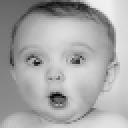

In [79]:
!pip install Pillow
from PIL import Image
import base64
import io

imgOrigin = explanation["entity"]["input_features"][0]["full_image"]
img_data = base64.b64decode(imgOrigin)
OriginPic = Image.open(io.BytesIO(img_data)).resize((128, 128)).convert('RGBA')
display(OriginPic)

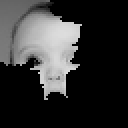

In [80]:
img = explanation["entity"]["predictions"][0]["explanation"][0]["full_image"]
img_data = base64.b64decode(img)
ExpPic = Image.open(io.BytesIO(img_data)).resize((128, 128)).convert('RGBA')
display(ExpPic)

In [81]:
Background = ExpPic.convert('RGBA')

# "data" is a height x width x 4 numpy array
data = np.array(Background)

# Temporarily unpack the bands for readability
red, green, blue, alpha = data.T 

# Replace white with red... (leaves alpha values alone...)
white_areas = (red != 0) | (blue != 0) | (green != 0)
data[..., :-1][white_areas.T] = (255, 0, 255) # Transpose back needed

Background = Image.fromarray(data)

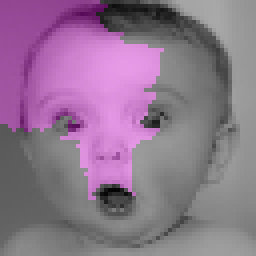

In [82]:
Image.blend(Background, OriginPic,alpha=0.7).resize((256,256))

In [ ]:
wml_client.repository.delete(model_uid)
deployment_id = wml_client.deployments.get_uid(deployment)
wml_client.deployments.delete(deployment_id)